--- RESULTADOS (Alvo: 43.2%) ---
Raiz Exata (Analítica): 1.4343735558 radianos

Resumo das Iterações:
                Tentativa            x      f(x)
Metodo                                          
Bissecção              19 1.4343739026  1.72e-07
Falsa Posição           4 1.4343731127 -2.20e-07
Newton-Raphson          2 1.4343735680  6.06e-09


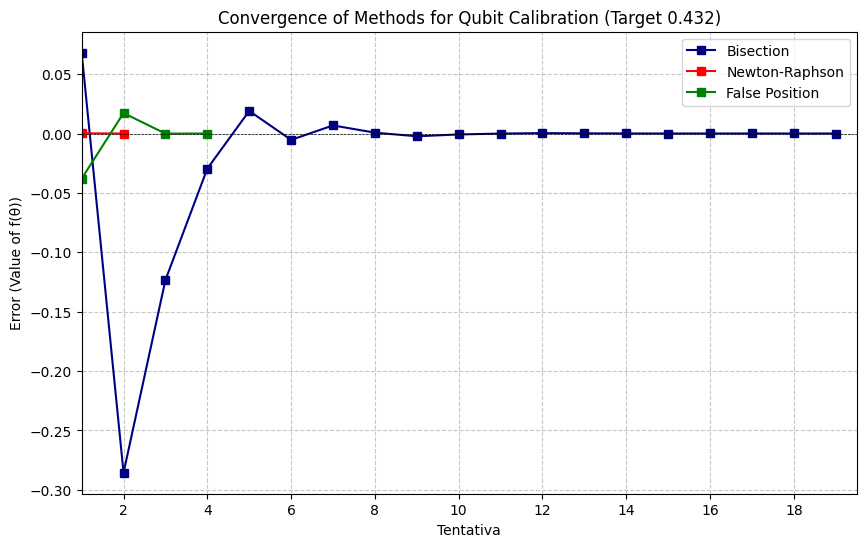

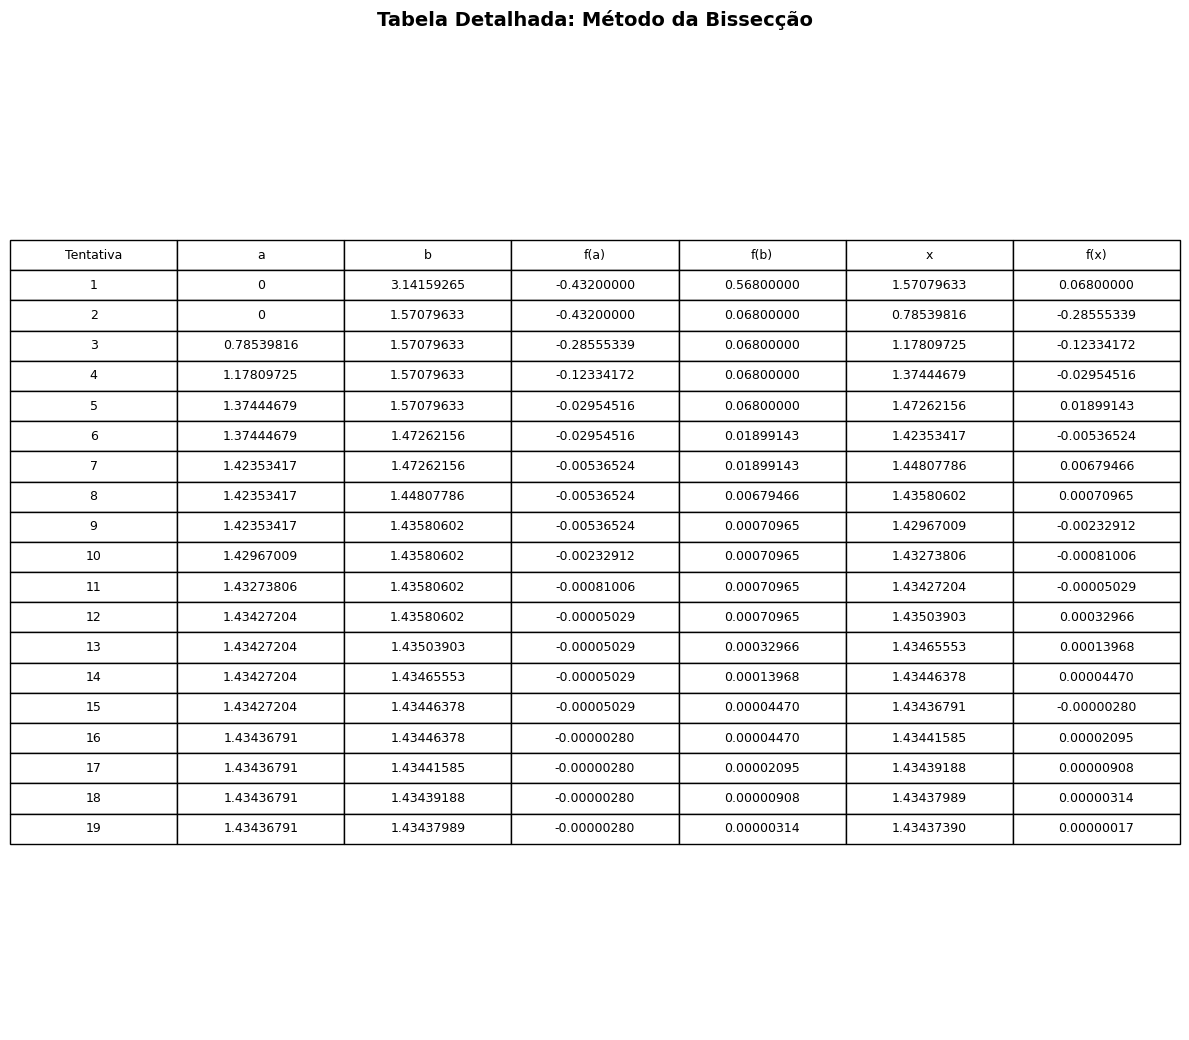

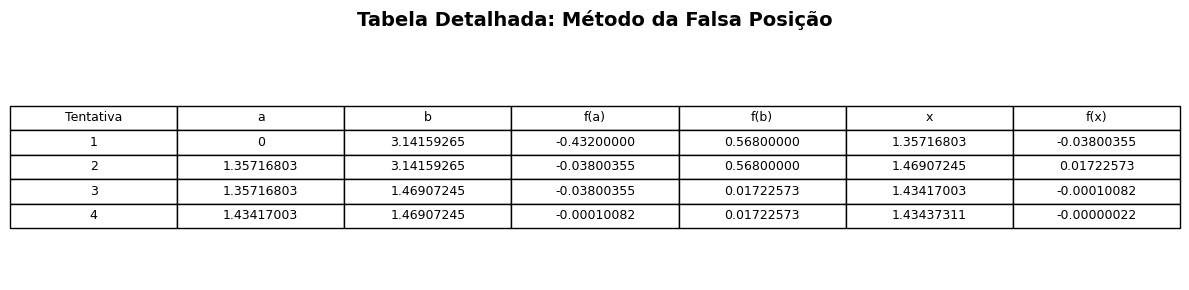

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Definição do alvo da calibração do Qubit (probabilidade exata de medir |1>)
P_TARGET = 0.432

# Função objetivo: f(theta) = Probabilidade_Calculada - Probabilidade_Alvo
def f(theta):
    return np.sin(theta / 2)**2 - P_TARGET

# Derivada da função (necessária pro método de Newton-Raphson)
def df(theta):
    return 0.5 * np.sin(theta)

# Implementação do Método da Bissecção
def metodo_bisseccao(a, b, stop, max_tentativas=100):
    dados = []
    # Checagem básica de troca de sinal no intervalo
    if f(a) * f(b) >= 0:
        return None, dados
    
    for k in range(max_tentativas):
        val_a = a
        val_b = b
        val_fa = f(a)
        val_fb = f(b)
        
        # Ponto médio
        x = (a + b) / 2
        val_fx = f(x)
        
        # Guardando o histórico pra plotar depois
        dados.append({
            'Metodo': 'Bissecção',
            'Tentativa': k + 1,      
            'a': val_a,
            'b': val_b,
            'f(a)': val_fa,
            'f(b)': val_fb,
            'x': x,
            'f(x)': val_fx
        })
        
        # Critério de parada
        if abs(val_fx) < stop:
            return x, dados
        
        # Atualiza o intervalo dependendo do sinal
        if val_fa * val_fx < 0:
            b = x
        else:
            a = x
            
    return x, dados

# Implementação do Método da Falsa Posição
def metodo_falsa_posicao(a, b, tol, max_tentativas=100):
    dados = []
    if f(a) * f(b) >= 0: return None, dados
    
    for k in range(max_tentativas):
        val_a = a
        val_b = b
        val_fa = f(a)
        val_fb = f(b)
        
        # Calcula a raiz aproximada pela média ponderada
        x = (a * abs(val_fb) + b * abs(val_fa)) / (abs(val_fb) + abs(val_fa))
        val_fx = f(x)
        
        dados.append({
            'Metodo': 'Falsa Posição',
            'Tentativa': k + 1,
            'a': val_a,
            'b': val_b,
            'f(a)': val_fa,
            'f(b)': val_fb,
            'x': x,
            'f(x)': val_fx
        })
        
        if abs(val_fx) < tol:
            return x, dados
        
        # Ajuste do intervalo
        if val_fa * val_fx < 0:
            b = x
        else:
            a = x
    return x, dados

# Implementação do Newton-Raphson
def metodo_newton_raphson(x0, tol, max_tentativas=100):
    dados = []
    x = x0
    for k in range(max_tentativas):
        fx = f(x)
        dfx = df(x)
        
        # Evita divisão por zero
        if dfx == 0: break
        
        # Canditado a raiz
        x_novo = x - (fx / dfx)
        
        dados.append({
            'Metodo': 'Newton-Raphson', 
            'Tentativa': k + 1, 
            'x': x_novo, 
            'f(x)': f(x_novo)
        })
        
        if abs(f(x_novo)) < tol:
            return x_novo, dados
        x = x_novo
    return x, dados

# Configuração da execução
criterio_de_parada = 0.000001

# Definindo intervalo de busca entre 0 e Pi e rodando os métodos
root_bis, dados_bis = metodo_bisseccao(0, np.pi, criterio_de_parada)
root_fal, dados_fal = metodo_falsa_posicao(0, np.pi, criterio_de_parada)
# Pro Newton, começo do meio do intervalo (Pi/2)
root_new, dados_new = metodo_newton_raphson(np.pi/2, criterio_de_parada)

# Juntando tudo num DataFrame pra facilitar a análise
df_results = pd.concat([
    pd.DataFrame(dados_bis),
    pd.DataFrame(dados_fal),
    pd.DataFrame(dados_new)
], sort=False)

print(f"--- RESULTADOS (Alvo: {P_TARGET*100}%) ---")
# Cálculo analítico só pra ter o "gabarito" e comparar a precisão
print(f"Raiz Exata (Analítica): {2 * np.arcsin(np.sqrt(P_TARGET)):.10f} radianos")
print("\nResumo das Iterações:")

# Pegando a última linha de cada método pra mostrar onde cada um parou
resumo = df_results.groupby('Metodo').last()[['Tentativa', 'x', 'f(x)']]

# Formatando a saída pra ficar mais legível (10 casas decimais no x pra ver a precisão)
print(resumo.to_string(formatters={
    'x': '{:.10f}'.format,       
    'f(x)': '{:.2e}'.format      
}))



# Visualização dos Resultados

# 1. Gráfico de Convergência
plt.figure(figsize=(10, 6))

methods_config = [
    ('Bisection', dados_bis, 'navy'),
    ('Newton-Raphson', dados_new, 'red'),
    ('False Position', dados_fal, 'green')
]

max_t = 0
for nome, dados, cor in methods_config:
    tentativas = [d['Tentativa'] for d in dados]
    valores = [d['f(x)'] for d in dados]
    
    # Atualiza o máximo de tentativas pra ajustar o eixo X depois
    if len(tentativas) > 0:
        max_t = max(max_t, max(tentativas))
        
    plt.plot(tentativas, valores, '-s', label=nome, color=cor)

plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.title(f'Convergence of Methods for Qubit Calibration (Target {P_TARGET})')
plt.xlabel('Interactions')
plt.ylabel('Error (Value of f(θ))')

# Ajuste para o eixo X a usar inteiros
plt.xlim(left=1, right=max_t + 0.5 if max_t > 0 else None)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) 

plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.show()

# Função auxiliar pra renderizar a tabela direto no plot
# Fica melhor pra colocar no relatório final
def plot_table(title, data, columns):
    cell_text = []
    for row in data:
        formatted_row = []
        for col in columns:
            # Tratamento pra evitar erro no Newton que não tem colunas 'a' e 'b'
            val = row.get(col, '') 
            if isinstance(val, (float, np.floating)):
                formatted_row.append(f"{val:.8f}")
            else:
                formatted_row.append(str(val))
        cell_text.append(formatted_row)
        
    fig, ax = plt.subplots(figsize=(12, len(data) * 0.5 + 1))
    ax.axis('off')
    ax.set_title(title, fontsize=14, weight='bold', pad=20)
    
    table = ax.table(cellText=cell_text, colLabels=columns, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    plt.tight_layout()
    plt.show()

cols_table = ['Tentativa', 'a', 'b', 'f(a)', 'f(b)', 'x', 'f(x)']

# Gerando as tabelas detalhadas passo a passo
plot_table("Tabela Detalhada: Método da Bissecção", dados_bis, cols_table)
plot_table("Tabela Detalhada: Método da Falsa Posição", dados_fal, cols_table)